In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import autosklearn.classification

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

/home/peiwang/anaconda3/lib/python3.7/site-packages/pyparsing.py:3168: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [2]:
def update_data(X_pool, y_pool, remove_list):
    X_pool_new = []
    y_pool_new = []
    for i in range(0, len(y_pool)):
        if i in remove_list:
            pass
        else:
            X_pool_new.append(X_pool[i])
            y_pool_new.append(y_pool[i])
    return X_pool_new, y_pool_new

In [3]:
def get_uncertain_data(clf, X_pool, y_pool, batch_size):
    y_ac_proba = clf.predict_proba(X_pool)
    
    # calculate
    y_ac_proba_abs = [abs(i[0] - i[1]) for i in y_ac_proba]
    
    # sorting
    abs_asc = np.argsort(y_ac_proba_abs)
    
    #print(abs_asc)
    
    count = 0
    sel_uncertain_list = []
    X_ac = []
    y_ac_label = []
    
    for m in range(len(y_pool)):
        i = abs_asc[m]
        if count < batch_size:
            count += 1
            X_ac.append(X_pool[i])
            y_ac_label.append(y_pool[i])
            sel_uncertain_list.append(i)
            
    #print(count)
#     print('uncertain instances:')
#     for i in sel_uncertain_list:
#         print((i, y_ac_proba[i]))
#     print('\n')
    return sel_uncertain_list, X_ac, y_ac_label

In [4]:
def get_infer_data(clf, X_pool, y_pool, pos_infer_num, neg_infer_num):
    y_infer_proba = clf.predict_proba(X_pool)
    y_infer_predict = clf.predict(X_pool)
    
    # calculate diff
    y_infer_proba_diff = [i[0] - i[1] for i in y_infer_proba]
    
    # sorting
    diff_asc = np.argsort(y_infer_proba_diff)
    diff_dec = list(reversed(diff_asc))
    
    # collecting
    count_pos = 0
    count_neg = 0
    
    sel_infer_list = []
    X_infer = []
    y_infer = []
    
    for m in range(len(y_pool)):
        i = diff_dec[m]
        if y_infer_proba_diff[i] > 0 and count_neg < neg_infer_num:
            count_neg += 1
            X_infer.append(X_pool[i])
            y_infer.append(y_infer_predict[i])
            sel_infer_list.append(i)

        i = diff_asc[m]
        if y_infer_proba_diff[i] < 0 and count_pos < pos_infer_num:
            count_pos += 1
            X_infer.append(X_pool[i])
            y_infer.append(y_infer_predict[i])
            sel_infer_list.append(i)
            
    #print(count_pos, count_neg)
#     print('inferred instances:')
#     for i in sel_infer_list:
#         print((i, y_infer_proba[i]))
#     print('\n')
    return sel_infer_list, X_infer, y_infer

In [5]:
def self_and_ac(start_data, pool_data, test_data, ac_batch_size, infer_batch_factor, iter_num):
    init_start_data = start_data
    X_start = start_data.drop(['label'], axis=1).values.tolist()
    y_start = start_data['label'].values.tolist()
    num_pos = len(start_data[start_data['label'] == 1])
    num_neg = len(start_data[start_data['label'] == 0])
    
#     print('start:', start_data.shape, 'pool:', pool_data.shape, 'test:', test_data.shape)
#     print('pos_num:', num_pos, 'neg_num:', num_neg, 'ac_batch_size:', ac_batch_size, '\n')
#     print('hybrid algorithm goes:')
    
    X_pool = pool_data.drop(['label'], axis=1).values.tolist()
    y_pool = pool_data['label'].values.tolist()
    
    X_test = test_data.drop(['label'], axis=1).values.tolist()
    y_test = test_data['label'].values.tolist()
    
    clf = RandomForestClassifier(random_state=0, n_estimators=10)
    clf.fit(X_start, y_start)
    num = 0
    init_label_num = len(y_start)
    f_change = []
    
    
    while num < iter_num:
        # print('iter:', num + 1, 'start:', len(y_start), 'pool:', len(y_pool), 'test:', len(y_test), 'label_num:', init_label_num + ac_batch_size * num)
        # evaluate on test data
        y_predict = clf.predict(X_test)
        cur_fscore = metrics.f1_score(y_test, y_predict)
        # print(cur_fscore)
        f_change.append(round(cur_fscore, 3))
        
        pos_infer_num = int(num_pos * infer_batch_factor)
        neg_infer_num = int(num_neg * infer_batch_factor)
        sel_infer_list, X_infer, y_infer = get_infer_data(clf, X_pool, y_pool, pos_infer_num, neg_infer_num)
        sel_uncertain_list, X_ac, y_ac_label = get_uncertain_data(clf, X_pool, y_pool, ac_batch_size)
        
        # update data
        X_start.extend(X_infer)
        X_start.extend(X_ac)
        y_start.extend(y_infer)
        y_start.extend(y_ac_label)
        
        # update data pool: delete by index list
        sel_infer_list.extend(sel_uncertain_list)
        X_pool, y_pool = update_data(X_pool, y_pool, sel_infer_list)
        
        # update_model
        clf.fit(X_start, y_start)
        num += 1
    
    # final evaluation on test data
    # print('iter:', num + 1, 'start:', len(y_start), 'pool:', len(y_pool), 'test:', len(y_test), 'label_num:', init_label_num + ac_batch_size * num)
    y_predict = clf.predict(X_test)
    cur_fscore = metrics.f1_score(y_test, y_predict)
    # print(cur_fscore)
    f_change.append(round(cur_fscore, 3))
    
    X_names = list(start_data.columns)
    X_names.remove('label')
    X_df = pd.DataFrame(X_start, columns=X_names)
    y_df = pd.DataFrame(y_start, columns=['label'])
    
    return f_change, pd.concat([X_df, y_df], axis=1)

In [58]:
self_label = [0, 20, 50, 100]
init_data = [30]
ac_batch = [10]
iter_num = 10

results_rf = []
results_auto = []

i = 8
for random_seed in range(10, 15):
    print("round:", random_seed)
    for init_data_num in init_data:
        for ac_batch_size in ac_batch:
            rf = []
            auto = []
            for l_num in self_label:
                train_path = './02-feature-extract-ori/features/ft_' + str(i) + '_train.csv'
                test_path = './02-feature-extract-ori/features/ft_' + str(i) + '_test.csv'
                train_data = pd.read_csv(train_path)
                test_data = pd.read_csv(test_path)
            
                initial_perc = init_data_num * 1.0 / len(train_data)
                inference_factor = l_num * 1.0 / init_data_num
                start_data, pool_data = train_test_split(train_data, train_size=initial_perc, random_state=random_seed)
                #print('start_data size:', len(start_data), 'pool_data size:', len(pool_data), 'test_data size:', len(test_data))
                #print('init_data_num:', init_data_num, 'batch_size:', ac_batch_size, 'infer_label_num:', l_num)
                fscore_hybrid, labeled_data_hybrid = self_and_ac(start_data, pool_data, test_data, ac_batch_size, inference_factor, iter_num)
                rf.append(fscore_hybrid[-1])
                print(len(labeled_data_hybrid), fscore_hybrid)
        
#             automl = autosklearn.classification.AutoSklearnClassifier(
#                 include_estimators=['random_forest'], 
#                 time_left_for_this_task=300, 
#                 initial_configurations_via_metalearning=0, 
#                 seed = 1,
#                 ensemble_nbest=1, 
#                 ensemble_size=1, 
#                 resampling_strategy='holdout',
#                 resampling_strategy_arguments={'train_size':0.75, 'random_state':42}
#             )
#             X_train = np.array(labeled_data_hybrid.drop(['label'], axis=1).values.tolist())
#             y_train = np.array(labeled_data_hybrid['label'].values.tolist())
#             X_test = np.array(test_data.drop(['label'], axis=1).values.tolist())
#             y_test = np.array(test_data['label'].values.tolist())
#             automl.fit(X_train, y_train, metric=autosklearn.metrics.f1)
#             print("auto:", automl.score(X_test, y_test))
#             auto.append(automl.score(X_test, y_test))
        
            print('RF:', 'init_data_num:', init_data_num, 'batch_size:', ac_batch_size)
            #print(auto)
            print(rf, '\n')
            results_rf.append(rf)
            results_auto.append(auto)

round: 10
130 [0.09, 0.167, 0.264, 0.296, 0.299, 0.271, 0.274, 0.368, 0.421, 0.364, 0.395]
330 [0.09, 0.251, 0.223, 0.256, 0.331, 0.373, 0.337, 0.376, 0.354, 0.336, 0.362]
630 [0.09, 0.169, 0.213, 0.233, 0.242, 0.272, 0.317, 0.317, 0.369, 0.331, 0.339]
1130 [0.09, 0.221, 0.245, 0.244, 0.276, 0.239, 0.287, 0.307, 0.254, 0.327, 0.319]
RF: init_data_num: 30 batch_size: 10
[0.395, 0.362, 0.339, 0.319] 

round: 11
130 [0.072, 0.227, 0.307, 0.263, 0.211, 0.198, 0.3, 0.338, 0.383, 0.379, 0.399]
320 [0.072, 0.255, 0.355, 0.309, 0.321, 0.349, 0.347, 0.382, 0.346, 0.341, 0.349]
620 [0.072, 0.185, 0.299, 0.303, 0.203, 0.343, 0.375, 0.372, 0.35, 0.349, 0.342]
1120 [0.072, 0.326, 0.23, 0.369, 0.32, 0.362, 0.32, 0.336, 0.364, 0.372, 0.358]
RF: init_data_num: 30 batch_size: 10
[0.399, 0.349, 0.342, 0.358] 

round: 12
130 [0.19, 0.179, 0.197, 0.197, 0.244, 0.307, 0.307, 0.341, 0.364, 0.352, 0.387]
320 [0.19, 0.183, 0.275, 0.269, 0.278, 0.278, 0.314, 0.314, 0.25, 0.254, 0.29]
620 [0.19, 0.229, 0.306, 0

ValueError: x and y must have same first dimension, but have shapes (4,) and (0,)

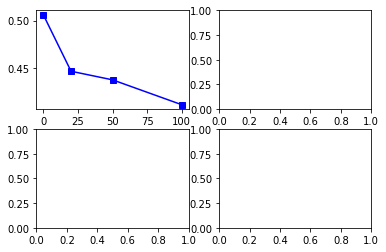

In [45]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(self_label, results_rf[0], 'b-s')
axs[0, 0].plot(self_label, results_auto[0], 'r-s')
axs[0, 0].set_title("init = " + str(init_data[0]) + ", batch = " + str(ac_batch[0]))
axs[0, 0].set_ylim([0, 0.7])

axs[0, 1].plot(self_label, results_rf[1], 'b-s')
axs[0, 1].plot(self_label, results_auto[1], 'r-s')
axs[0, 1].set_title("init = " + str(init_data[0]) + ", batch = " + str(ac_batch[1]))
# axs[0, 1].set_ylim([0, 0.6])

# axs[0, 2].plot(self_label, results_rf[2], 'b-s')
# axs[0, 2].set_title("init = " + str(init_data[0]) + ", batch = " + str(ac_batch[2]))
# axs[0, 2].set_ylim([0, 0.6])

axs[1, 0].plot(self_label, results_rf[2], 'b-s')
axs[1, 0].plot(self_label, results_auto[2], 'r-s')
axs[1, 0].set_title("init = " + str(init_data[1]) + ", batch = " + str(ac_batch[0]))
# axs[1, 0].set_ylim([0, 0.6])

axs[1, 1].plot(self_label, results_rf[3], 'b-s')
axs[1, 1].plot(self_label, results_auto[3], 'r-s')
axs[1, 1].set_title("init = " + str(init_data[1]) + ", batch = " + str(ac_batch[1]))
# axs[1, 1].set_ylim([0, 0.6])

# axs[1, 2].plot(self_label, results_rf[5], 'b-s')
# axs[1, 2].set_title("init = " + str(init_data[1]) + ", batch = " + str(ac_batch[2]))
# axs[1, 2].set_ylim([0, 0.6])

# axs[2, 0].plot(self_label, results_rf[6], 'b-s')
# axs[2, 0].set_title("init = " + str(init_data[2]) + ", batch = " + str(ac_batch[0]))
# axs[2, 0].set_ylim([0, 0.6])

# axs[2, 1].plot(self_label, results_rf[7], 'b-s')
# axs[2, 1].set_title("init = " + str(init_data[2]) + ", batch = " + str(ac_batch[1]))
# axs[2, 1].set_ylim([0, 0.6])

# axs[2, 2].plot(self_label, results_rf[8], 'b-s')
# axs[2, 2].set_title("init = " + str(init_data[2]) + ", batch = " + str(ac_batch[2]))
# axs[2, 2].set_ylim([0, 0.6])

fig.set_size_inches(9, 6)
fig.legend(['rf','auto'])
fig.tight_layout()

IndexError: list index out of range

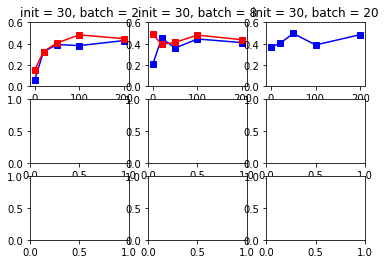

In [34]:
fig, axs = plt.subplots(3, 3)

axs[0, 0].plot(self_label, results_rf[0], 'b-s')
axs[0, 0].plot(self_label, results_auto[0], 'r-s')
axs[0, 0].set_title("init = 30, batch = 2")
axs[0, 0].set_ylim([0, 0.6])

axs[0, 1].plot(self_label, results_rf[1], 'b-s')
axs[0, 1].plot(self_label, results_auto[1], 'r-s')
axs[0, 1].set_title("init = 30, batch = 8")
axs[0, 1].set_ylim([0, 0.6])

axs[0, 2].plot(self_label, results_rf[2], 'b-s')
#axs[0, 2].plot(self_label, results_auto[2], 'o-s')
axs[0, 2].set_title("init = 30, batch = 20")
axs[0, 2].set_ylim([0, 0.6])

axs[1, 0].plot(self_label, results_rf[3], 'b-s')
#axs[1, 0].plot(self_label, results_auto[3], 'o-s')
axs[1, 0].set_title("init = 100, batch = 2")
axs[1, 0].set_ylim([0, 0.6])

axs[1, 1].plot(self_label, results_rf[4], 'b-s')
#axs[1, 1].plot(self_label, results_auto[4], 'o-s')
axs[1, 1].set_title("init = 100, batch = 8")
axs[1, 1].set_ylim([0, 0.6])

axs[1, 2].plot(self_label, results_rf[5], 'b-s')
#axs[1, 2].plot(self_label, results_auto[5], 'o-s')
axs[1, 2].set_title("init = 100, batch = 20")
axs[1, 2].set_ylim([0, 0.6])

axs[2, 0].plot(self_label, results_rf[6], 'b-s')
#axs[2, 0].plot(self_label, results_auto[6], 'o-s')
axs[2, 0].set_title("init = 500, batch = 2")
axs[2, 0].set_ylim([0, 0.6])

axs[2, 1].plot(self_label, results_rf[7], 'b-s')
#axs[2, 1].plot(self_label, results_auto[7], 'o-s')
axs[2, 1].set_title("init = 500, batch = 8")
axs[2, 1].set_ylim([0, 0.6])

axs[2, 2].plot(self_label, results_rf[8], 'b-s')
# axs[2, 2].plot(self_label, results_auto[8], 'o-s')
axs[2, 2].set_title("init = 500, batch = 20")
axs[2, 2].set_ylim([0, 0.6])

fig.set_size_inches(9, 6)
fig.legend(['rf','auto'])
fig.tight_layout()